# Define morphological models with `neat.PhysTree`
The Class `neat.PhysTree` is used to define the physiological parameters of neuron models. It inherits from `neat.MorphTree` and thus has all its functionality. Just as `neat.MorphTree`, instances are initialized based on the standard `.swc` format:

In [1]:
from neat import PhysTree
ph_tree = PhysTree('morph/purkinje1.swc')

Cannot load crlibm extension. The imath functions will not be available.



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Apr  8 2025 14:50:44

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



## Defining physiological parameters

A `PhysTree` consists of `neat.PhysNode` instances, which inherit from `neat.MorphNode`. Compared to a `MorphNode`, a `PhysNode` has extra attributes (initialized to some default value) defining physiological parameters:

In [2]:
# specific membrance capacitance (uF/cm^2)
print('default c_m node 1:', ph_tree[1].c_m)
# axial resisitance (MOhm*cm)
print('default r_a node 1:', ph_tree[1].r_a)
# point-like shunt located at {'node': node.index, 'x': 1.} (uS)
print('default g_shunt node 1:', ph_tree[1].g_shunt)
# leak and ion channel currents, stored in a dict with
# key: 'channel_name', value: [g_max, e_rev]
print('default currents node 1:', ph_tree[1].currents)

default c_m node 1: 1.0
default r_a node 1: 9.999999999999999e-05
default g_shunt node 1: 0.0
default currents node 1: {}


It is not recommended, and for ion channels even forbidden, to set the parameters directly via the nodes. Rather, the parameters should be specified with associated functions of `PhysTree`. These functions accept a `node_arg` keyword argument, which allows selecting a specific set of nodes. Parameters, can be given as `float`, in which case all nodes in `node_arg` will be set to the same value, a `dict` of `{node.index: parameter_value}`, or a callable function where the input is the distance of the middle of the node (`loc = {'node': node.index, 'x': .5}`) to the soma and the output the parameter.

Let's use `PhysTree.set_physiology()` to set capacitance (1st argument) and axial resistance (2nd argument) in the whole tree:

In [3]:
ph_tree.set_physiology(lambda x: .8 if x < 60. else 1.6*.8, 100.*1e-6)

Here, we defined the capacitance to be $.8$ $\mu$F/cm$^2$ when the mid-point of the node is less than 60 $\mu$m from the soma and $1.6*.8$ $\mu$F/cm$^2$, a common factor to take dendritic spines into account. Axial resistance was set to a constant value throughout the tree.

To set ion channels (see the 'Ionchannels in NEAT' tutorial on how to create your own ion channels), we must create the ion channel instance first. Here, we'll set a default sodium and potassium channel:

In [4]:
from neat.channels.channelcollection.channelcollection import NaF, NaP, KM, KA, Kh, Khh, KD, KC3, CaE, CaT, CaP2, K23, Na_Ta, Kv3_1, SK
# create the ion channel instances
naf_chan = NaF()
nap_chan = NaP()
k23_chan = K23()
km_chan = KM()
ka_chan = KA()
kh_chan = Kh()
khh_chan = Khh()
kd_chan = KD()
kc3_chan = KC3()
cae_chan = CaE()
cat_chan = CaT()
cap2_chan = CaP2()
na_chan = Na_Ta()
k_chan = Kv3_1()
sk_chan = SK()
# set the channels at the soma or throughout the dendritic tree with their conductances and reversal potentials
ph_tree.add_channel_current(na_chan, 1.71*1e6, 50., node_arg=[ph_tree[1]])
ph_tree.add_channel_current(k_chan,0.45*1e6, -85., node_arg=[ph_tree[1]])
ph_tree.add_channel_current(ka_chan, 0.08, -85.)
ph_tree.add_channel_current(kd_chan, 0.09, -85.)
ph_tree.add_channel_current(cae_chan, 0.008, 135.)
ph_tree.add_channel_current(cap2_chan, 0.004, 135.)
ph_tree.add_channel_current(na_chan, 1.71*1e6, 50.)
ph_tree.add_channel_current(k_chan,0.45*1e6, -85.)
ph_tree.add_channel_current(sk_chan, 0.01, -85.)

Now, we only have to set the leak current. We have two possibilities for this: (i) we could set the leak current by providing conductance and reversal in the standard way with `PhysTree.set_leak_current()` or (ii) with could fit the leak current to fix equilibrium potential and membrane time scale (if possible) with `PhysTree.fit_leak_current()`. We take the second option here:

In [5]:
# fit leak current to yield an equilibrium potential of -70 mV and
# a total membrane time-scale of 10 ms (with channel opening 
# probabilities evaluated at -70 mV)
#ph_tree.fit_leak_current(-80., 0.0006)
#ph_tree.set_leak_current(-80., 0.0006)
ph_tree.set_leak_current(0.0006*1e6, -80.)
ph_tree.set_comp_tree()

## Inspecting the physiological parameters

We can now inspect the contents of various `PhysNode` instances:

In [6]:
# soma node
print(ph_tree[1])

PhysNode 1, Parent: None --- r_a = 0.0001 MOhm*cm, c_m = 0.8 uF/cm^2, v_ep = -75 mV, (g_Na_Ta = 1.71e+06 uS/cm^2, e_Na_Ta = 50 mV), (g_Kv3_1 = 450000 uS/cm^2, e_Kv3_1 = -85 mV), (g_KA = 0.08 uS/cm^2, e_KA = -85 mV), (g_KD = 0.09 uS/cm^2, e_KD = -85 mV), (g_CaE = 0.008 uS/cm^2, e_CaE = 135 mV), (g_CaP2 = 0.004 uS/cm^2, e_CaP2 = 135 mV), (g_SK = 0.01 uS/cm^2, e_SK = -85 mV), (g_L = 600 uS/cm^2, e_L = -80 mV)


In [7]:
# dendrite node
print(ph_tree[115])

PhysNode 115, Parent: 114 --- r_a = 0.0001 MOhm*cm, c_m = 1.28 uF/cm^2, v_ep = -75 mV, (g_KA = 0.08 uS/cm^2, e_KA = -85 mV), (g_KD = 0.09 uS/cm^2, e_KD = -85 mV), (g_CaE = 0.008 uS/cm^2, e_CaE = 135 mV), (g_CaP2 = 0.004 uS/cm^2, e_CaP2 = 135 mV), (g_Na_Ta = 1.71e+06 uS/cm^2, e_Na_Ta = 50 mV), (g_Kv3_1 = 450000 uS/cm^2, e_Kv3_1 = -85 mV), (g_SK = 0.01 uS/cm^2, e_SK = -85 mV), (g_L = 600 uS/cm^2, e_L = -80 mV)


Or, to get the full information on conductances and reversal potentials of membrane currents:

In [8]:
# soma node
print(ph_tree[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'KA': [0.08, -85.0], 'KD': [0.09, -85.0], 'CaE': [0.008, 135.0], 'CaP2': [0.004, 135.0], 'SK': [0.01, -85.0], 'L': [600.0, -80.0]}


In [9]:
# dendrite node
print(ph_tree[115].currents)

{'KA': [0.08, -85.0], 'KD': [0.09, -85.0], 'CaE': [0.008, 135.0], 'CaP2': [0.004, 135.0], 'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'SK': [0.01, -85.0], 'L': [600.0, -80.0]}


## Active dendrites compared to closest passive version

Imagine we aim to investigate the role of active dendritic channels, and to that purpose want to compare the active dendritic tree with a passive version. We may compute the leak conductance of this "passified" tree as the sum of all ion channel conductance evaluate at the equilibrium potential. The equilibrium potentials is stored on the tree using `PhysTree.set_v_ep()`:

In [10]:
ph_tree.set_v_ep(-70.)

To obtain the passified tree, we use `PhysTree.as_passive_membrane()`. However, this function will overwrite the parameters of the original nodes, if we want to maintain the initial tree, we have to copy it first:

In [11]:
# copy the initial tree
ph_tree_pas = PhysTree(ph_tree)
# set to passive (except the soma)
ph_tree_pas.as_passive_membrane([n for n in ph_tree_pas if n.index != 1])

We can now inspect the nodes:

In [12]:
# soma node
print(ph_tree_pas[1])

PhysNode 1, Parent: None --- r_a = 0.0001 MOhm*cm, c_m = 0.8 uF/cm^2, v_ep = -70 mV, (g_Na_Ta = 1.71e+06 uS/cm^2, e_Na_Ta = 50 mV), (g_Kv3_1 = 450000 uS/cm^2, e_Kv3_1 = -85 mV), (g_KA = 0.08 uS/cm^2, e_KA = -85 mV), (g_KD = 0.09 uS/cm^2, e_KD = -85 mV), (g_CaE = 0.008 uS/cm^2, e_CaE = 135 mV), (g_CaP2 = 0.004 uS/cm^2, e_CaP2 = 135 mV), (g_SK = 0.01 uS/cm^2, e_SK = -85 mV), (g_L = 600 uS/cm^2, e_L = -68.8771 mV)


In [13]:
# dendrite node
print(ph_tree_pas[115])

PhysNode 115, Parent: 114 --- r_a = 0.0001 MOhm*cm, c_m = 1.28 uF/cm^2, v_ep = -70 mV, (g_KA = 0.08 uS/cm^2, e_KA = -85 mV), (g_KD = 0.09 uS/cm^2, e_KD = -85 mV), (g_CaE = 0.008 uS/cm^2, e_CaE = 135 mV), (g_CaP2 = 0.004 uS/cm^2, e_CaP2 = 135 mV), (g_Na_Ta = 1.71e+06 uS/cm^2, e_Na_Ta = 50 mV), (g_Kv3_1 = 450000 uS/cm^2, e_Kv3_1 = -85 mV), (g_SK = 0.01 uS/cm^2, e_SK = -85 mV), (g_L = 600 uS/cm^2, e_L = -68.8771 mV)


And the currents:

In [14]:
# soma node
print(ph_tree_pas[1].currents)

{'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'KA': [0.08, -85.0], 'KD': [0.09, -85.0], 'CaE': [0.008, 135.0], 'CaP2': [0.004, 135.0], 'SK': [0.01, -85.0], 'L': [600.0, -68.87708660049212]}


In [15]:
# dendrite node
print(ph_tree_pas[115].currents)

{'KA': [0.08, -85.0], 'KD': [0.09, -85.0], 'CaE': [0.008, 135.0], 'CaP2': [0.004, 135.0], 'Na_Ta': [1710000.0, 50.0], 'Kv3_1': [450000.0, -85.0], 'SK': [0.01, -85.0], 'L': [600.0, -68.87708660049212]}


Comparing this to the previously shown nodes of the full tree, we see that the dendrite nodes have been "passified".

## Computational tree

The computational tree in `PhysTree` works the same as in `MorphTree`, except that it's derivation also considers changes in physiological parameters, next to changes in morphological parameters.

In [16]:
ph_tree.set_comp_tree()
# compare number of nodes in computational tree and original tree
print('%d nodes in original tree'%(len(ph_tree)))
with ph_tree.as_computational_tree:
    print('%d nodes in computational tree'%(len(ph_tree)))

3112 nodes in original tree
3112 nodes in computational tree


Compare this to the number of nodes in the computational tree induced solely by the morphological parameters:

In [17]:
from neat import MorphTree
m_tree = MorphTree('morph/purkinje1.swc')
m_tree.set_comp_tree()
with ph_tree.as_computational_tree:
    print('%d nodes in computational `MorphTree`'%len(m_tree))

3112 nodes in computational `MorphTree`


Note: only call this `PhysTree.set_comp_tree` when all physiological parameters have been set, and ***never*** change parameters stored at individual nodes when the computational tree is active, as this leads to the computational tree being inconsistent with the original tree.

# Simulate models with `neat.NeuronSimTree`

NEAT implements an interface to the NEURON simulator, so that models defined by neat-trees can be simulated with the NEURON simulator. To have access to this functionality, the NEURON simulator and it's Python interface need to be installed.

The class `neat.NeuronSimTree` implements this interface, and inherits from `neat.PhysTree`. Hence, a `NeuronSimTree` can be defined in the same way as a `PhysTree`.

In [18]:
from neat import NeuronSimTree
#sim_tree = NeuronSimTree('morph/L23PyrBranco.swc')
#sim_tree.set_physiology(lambda x: .8 if x < 60. else 1.6*.8, 100.*1e-6)
# ... etc

## Copying trees

If a different type of tree is needed than the one originally defined, or simply a copy of the original tree, we can use the copy construct functionality of `NEAT`'s trees: we can instantiate any tree class based on any other tree instance, and only the attributes that are shared amongst both instances will be copied over. Since `NeuronSimTree` is a subclass of `PhysTree`, we end up with an identical tree, but with additional functions and associated attributes to simulate the associated NEURON model.

In [19]:
sim_tree = NeuronSimTree(ph_tree)

## Setting up a simulation

To simulate a neuron model with active channels, we must first compile them. In the present model, we used the channels from the file `channelcollection_for_tutorial.py`. We can use the `neatmodels` terminal command to compile the channels, i.e. 

```
neatmodels install TutorialChannels -s neuron -p channelcollection_for_tutorial.py
```

This compiles all `neat.IonChannel`s in the file `channelcollection_for_tutorial.py` into NEURON. The command `neatmodels list` should then show the model `TutorialChannels`. Check out `neatmodels -h` to find out more about the compile command. This command can also be used to compile models into NEST.

We can load the `TutorialChannels` model in NEAT.

In [20]:
from neat import load_neuron_model
load_neuron_model('TutorialChannels')

After loading the `TutorialChannels`, the `sim_tree` featuring these channels can be simulated. First, we must initialize the tree structure into hoc.

In [21]:
sim_tree.init_model(t_calibrate=125.)

We may then add inputs to the tree. NEAT implements a number of standard synapse types and current injections. Let's apply a DC current step to the soma and also give some input to a conductance-based dendritic synapse.

In [22]:
# somatic DC current step with amplitude = 0.100 nA, delay = 5. ms and duration = 100. ms
sim_tree.add_i_clamp((1.,.5), 0., 5., 100.)
# dendritic synapse with rise resp. decay times of .2 resp 3. ms and reversal of 0 mV
sim_tree.add_double_exp_synapse((115,.8), .2, 3., 0.)
# give the dendritic synapse a weight of 0.005 uS and connect it to an input spike train
sim_tree.set_spiketrain(0, 0.05, [25.,50.,75.,100.])

We will record voltage at the somatic and dendritic site. Recording locations should be stored under the name 'rec locs'.

In [23]:
sim_tree.store_locs([(1,.5), (2000,.8), (700,.8), (500,.8)], name='rec locs')

We can then run the model for $60$ ms and plot the results:

In [24]:
# simulate the model and delete all hoc-variables afterwards
res = sim_tree.run(100.)
sim_tree.delete_model()

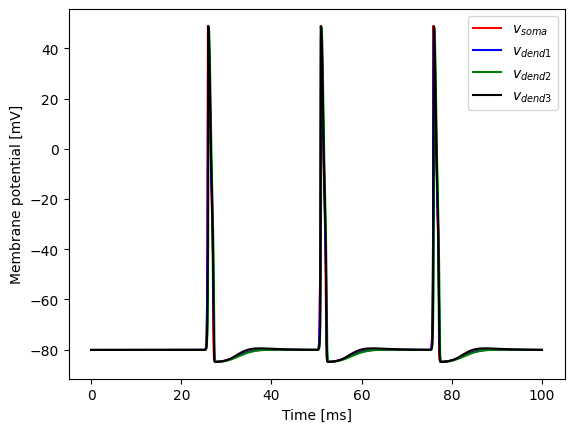

In [25]:
#plot the results
import matplotlib.pyplot as pl
pl.plot(res['t'], res['v_m'][0], c='r', label=r'$v_{soma}$')
pl.plot(res['t'], res['v_m'][1], c='b', label=r'$v_{dend1}$')
pl.plot(res['t'], res['v_m'][2], c='g', label=r'$v_{dend2}$')
pl.plot(res['t'], res['v_m'][3], c='k', label=r'$v_{dend3}$')

pl.xlabel('Time [ms]')
pl.ylabel('Membrane potential [mV]')

pl.legend(loc=0)
pl.show()

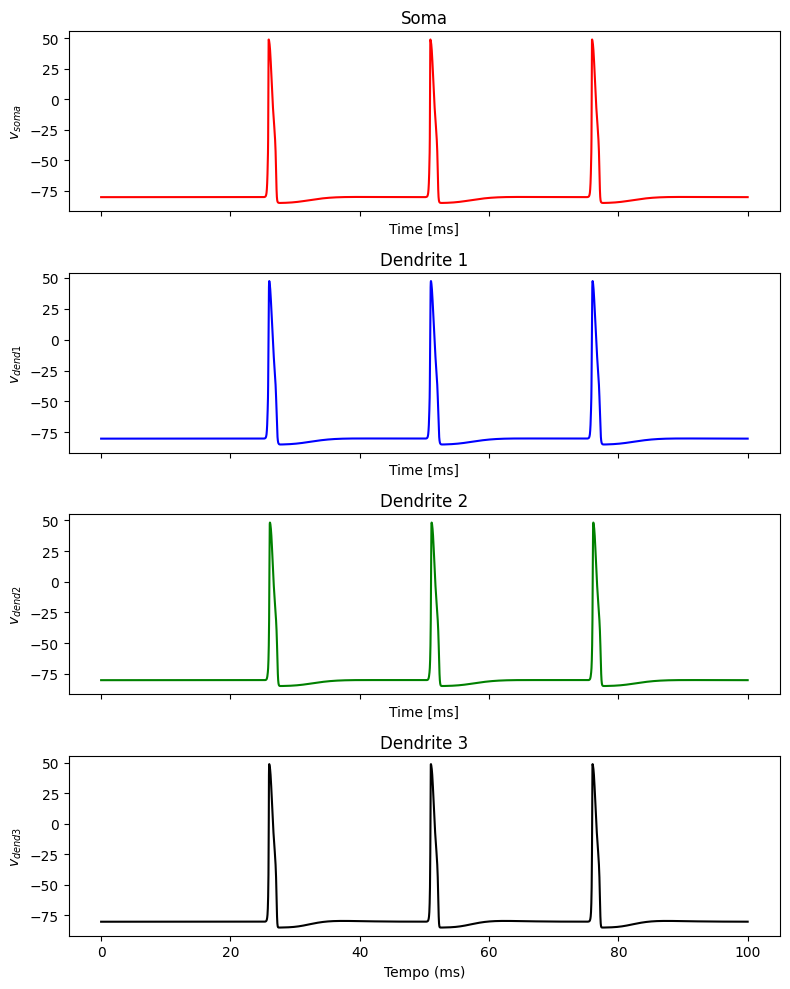

In [26]:
fig, axs = pl.subplots(4, 1, figsize=(8, 10), sharex=True)  # 4 righe, 1 colonna

axs[0].plot(res['t'], res['v_m'][0], c='r')
axs[0].set_xlabel(r'Time [ms]')
axs[0].set_ylabel(r'$v_{soma}$')
axs[0].set_title('Soma')

axs[1].plot(res['t'], res['v_m'][1], c='b')
axs[1].set_xlabel(r'Time [ms]')
axs[1].set_ylabel(r'$v_{dend1}$')
axs[1].set_title('Dendrite 1')

axs[2].plot(res['t'], res['v_m'][2], c='g')
axs[2].set_xlabel(r'Time [ms]')
axs[2].set_ylabel(r'$v_{dend2}$')
axs[2].set_title('Dendrite 2')

axs[3].plot(res['t'], res['v_m'][3], c='k')
axs[3].set_xlabel(r'Time [ms]')
axs[3].set_ylabel(r'$v_{dend3}$')
axs[3].set_title('Dendrite 3')
axs[3].set_xlabel('Tempo (ms)')

pl.tight_layout()
pl.show()

## User defined point-process

Note that it is very easy to add user defined point-process to the `NeuronSimTree`. In fact, all any of the default functions to add point-process do, is defining a `neat.MorphLoc` based on the input, so that the point process is added at the right coordinates no matter whether the original or computational tree was active. All hoc sections are stored in the dict `self.sections` which has as keys the node indices. Hence, in pseudo code one would do:

```
loc = neat.MorphLoc((node.index, x-coordinate), sim_tree)

# define the point process at the correct location
pp = h.user_defined_point_process(sim_tree.sections[loc['node']](loc['x']))

# set its parameters
pp.param1 = val1
pp.param2 = val2
...

# store the point process (e.g. if it is a synapse in `sim_tree.syns`)
sim_tree.syns.append(pp)
```

# Evaluate impedance matrices with `neat.GreensTree`

The class `neat.GreensTree` inherits from `neat.PhysTree` and implements Koch's algorithm [-@Koch1984] to calculate impedances in the Fourrier domain. For a given input current of frequency $\omega$ at location $x$, the impedance gives the linearized voltage response at a location $x^{\prime}$:
\begin{align}
v_{x^{\prime}}(\omega) = z_{x^{\prime}x}(\omega) \, i_x(\omega).
\end{align}
Applying the inverse Fourrier transform yields a convolution in the the time domain:
\begin{align}
v_{x^{\prime}}(t) = z_{x^{\prime}x}(t) \ast i_x(t),
\end{align}
with we call $z_{x^{\prime}x}(t) = FT^{-1} \left(  z_{x^{\prime}x}(\omega) \right)$ the impedance kernel. The steady state impedance is then:
\begin{align}
z_{x^{\prime}x} = \int_0^{\infty} \mathrm{d}t \, z_{x^{\prime}x}(t) = z_{x^{\prime}x}(\omega = 0).
\end{align}

## Computing an impedance kernel

To compute an impedance kernel, we first have to initialize the `GreensTree`:

In [27]:
from neat import GreensTree
greens_tree = GreensTree(ph_tree)

For the calculation to proceed efficiently, `GreensTree` first sets effective, frequency-dependent boundary conditions for each cylindrical section. Hence we must specify the frequencies at which we want to evaluate impedances. If we aim to also compute temporal kernels, `neat.FourierQuadrature` is a handy tool to obtain the correct frequencies. Suppose for instance that we aim to compute an impedance kernels from $0$ to $50$ ms:

In [28]:
import sys
sys.setrecursionlimit(10000)
from neat import FourierQuadrature
import numpy as np
# create a FourierQuadrature instance with the temporal array on which to evaluate the impedance kernel
t_arr = np.linspace(0.,50.,1000)
ft = FourierQuadrature(t_arr)
# appropriate frequencies are stored in `ft.s`
# set the boundary condition for cylindrical segments in `greens_tree`
greens_tree.set_impedance(ft.s)

We can now compute for instance the impedance kernel between dendritic and somatic site:

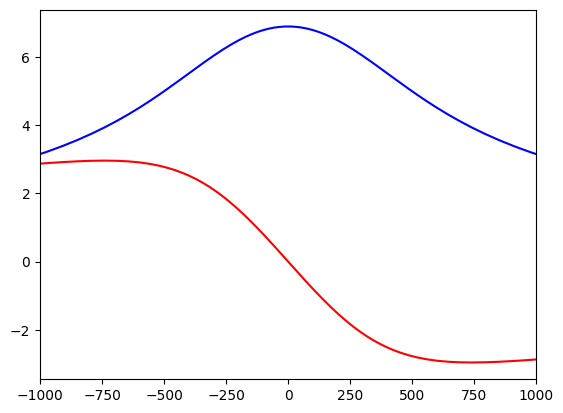

In [29]:
import matplotlib.pyplot as pl
z_trans = greens_tree.calc_zf((1,.5), (2000,.8))

# plot the kernel
pl.plot(ft.s.imag, z_trans.real, 'b')
pl.plot(ft.s.imag, z_trans.imag, 'r')
pl.xlim((-1000.,1000.))
pl.show()

We can also obtain this kernel in the time domain with the `FourierQuadrature` object:

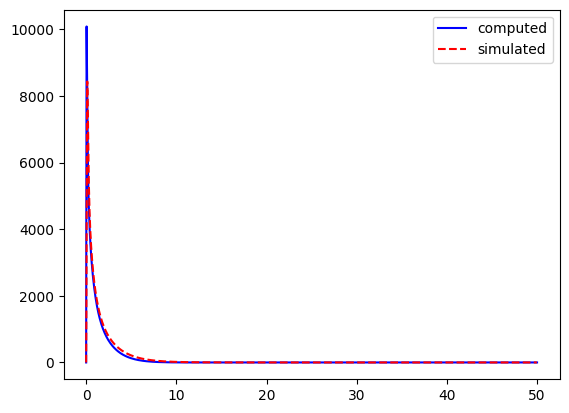

In [30]:
# time domain kernel
tt, zt = ft.ft_inv(z_trans)

# comparison with NEURON simulation
sim_tree.init_model(t_calibrate=300.)
i_amp, i_dur = 0.001, 0.1
sim_tree.add_i_clamp((2000,.8), i_amp, 0., i_dur)
res = sim_tree.run(50.)
sim_tree.delete_model()
res['v_m'] -= res['v_m'][:,-1]
res['v_m'] /= (i_amp*1e-3*i_dur)

# plot the kernel
pl.plot(tt, zt.real, 'b', label='computed')
pl.plot(res['t'], res['v_m'][0], 'r--', label='simulated')
pl.legend(loc=0)
pl.show()

## Computing the impedance matrix

While `GreensTree.calc_zf()` could be used to explicitely compute the impedance matrix, `GreensTree.calc_impedance_matrix()` uses the symmetry and transitivity properties of impedance kernels to further optimize the calculation.

In [31]:
z_locs = [(1,.5), (2000,.8)]
z_mat = greens_tree.calc_impedance_matrix(z_locs)

This matrix has shape ``(len(ft.s), len(z_locs), len(z_locs))``. The zero-frequency component is at `ft.ind_0s`. Hence, the following gives the steady state impedance matrix:

In [32]:
print(z_mat[ft.ind_0s])

[[15.05771087+0.j  6.88997215+0.j]
 [ 6.88997215+0.j 11.72691592+0.j]]


# Simplify a model with `neat.CompartmentFitter`

The class `neat.CompartmentFitter` is used to obtain simplified compartmental models, where the parameters of the compartments are optimized to reproduce voltages at any set of locations on the morphology. It is initialized based on a `neat.PhysTree`:

In [33]:
import sys
sys.setrecursionlimit(10000)

In [34]:
from neat import CompartmentFitter
c_fit = CompartmentFitter(ph_tree)


>>>> Cache file for CompartmentFitter:
    neatcache/_cache_37c98aec4ea49b7fe725519ccccfefda5111a84686ebde86b414891e116552e5.p
<<<<


The function `CompartmentFitter.fit_model()` then returns a `neat.CompartmentTree` object defining the simplified model, with the parameters of the optimized compartments:

In [35]:
# compute a simplified tree containing a somatic and dendritic compartment
f_locs = [(1,.5), (2000,.8)]
c_tree, c_locs = c_fit.fit_model(f_locs, use_all_channels_for_passive=False) # 

One way to understand whether the reduction will be faithful, is to check whether the passive reduced model reproduces the same impedance kernels as the full model. The `check_passive()` function of `neat.CompartmentFitter` allows the comparison of these kernels between full and reduced models:

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


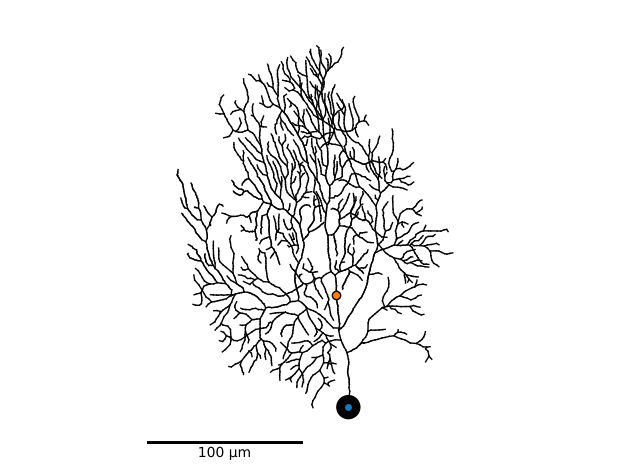

In [37]:
c_fit.check_passive(f_locs, use_all_channels_for_passive=False)

## The simplified model `neat.CompartmentTree`

Each `neat.CompartmentNode` in the `CompartmentTree` stores the optimized parameters of the compartment, and the coupling conductance with it's parent node.

In [38]:
print(c_tree)

>>> CompartmentTree
    CompartmentNode 0, Parent: None --- loc_idx = 0, g_c = 0.0 uS, ca = 6.95112364685386e-05 uF, e_eq = -80.13628438385213 mV, (g_L = 0.03418161691431276 uS, e_L = -80.08389567743383 mV), (g_Na_Ta = 51.18297240554776 uS, e_Na_Ta = 50.0 mV), (g_Kv3_1 = 9.874714288935369 uS, e_Kv3_1 = -85.0 mV), (g_KA = 2.411613669436097e-06 uS, e_KA = -85.0 mV), (g_KD = 2.713068941904751e-06 uS, e_KD = -85.0 mV), (g_CaE = 2.4116172568334153e-07 uS, e_CaE = 135.0 mV), (g_CaP2 = 1.205810472879352e-07 uS, e_CaP2 = 135.0 mV), (g_SK = 3.014521723118537e-07 uS, e_SK = -85.0 mV)
    CompartmentNode 1, Parent: 0 --- loc_idx = 1, g_c = 0.05450228917520163 uS, ca = 0.0001236463113116209 uF, e_eq = -80.13628438385022 mV, (g_L = 0.0579968887580488 uS, e_L = -80.09349413580671 mV), (g_Na_Ta = 93.03702392127744 uS, e_Na_Ta = 50.0 mV), (g_Kv3_1 = 13.717113325372125 uS, e_Kv3_1 = -85.0 mV), (g_KA = 4.385914378515942e-06 uS, e_KA = -85.0 mV), (g_KD = 4.934154444054061e-06 uS, e_KD = -85.0 mV), (g_CaE

To keep track of the mapping between compartments and locations, each `CompartmentNode` also has a `loc_idx` attribute, containing the index of the location in the original list given to `CompartmentFitter.fit_model()` (here `f_locs`) to which the compartment is fitted:

In [39]:
# node 0 corresponds to location 0 in `f_locs`
print('node index: %d, loc index: %d'%(c_tree[0].index, c_tree[0].loc_idx))
# node 1 corresponds to location 1 in `f_locs`
print('node index: %d, loc index: %d'%(c_tree[1].index, c_tree[1].loc_idx))

node index: 0, loc index: 0
node index: 1, loc index: 1


Here, these indices correspond, but in general there is ***no*** guarantee this will be the case. A list of 'fake' locations for the compartmental model can also be obtained. These locations contain nothing but the node index and an x-coordinate without meaning.

In [40]:
c_locs = c_tree.get_equivalent_locs()
print(c_locs[0], c_locs[1])

(0, 0.5) (1, 0.5)


## Simulate the simplified model with `neat.NeuronCompartmentTree`

The simplified model can be simulated directly in NEURON, with the same API as `neat.NeuronSimTree`. To do so, one can create a `neat.NeuronCompartmentTree` from an existing `neat.CompartmentTree`:

In [41]:
from neat import NeuronCompartmentTree
c_sim_tree = NeuronCompartmentTree(c_tree)

We may now check whether our simplification was successful by running the same simulation for the full and reduced models:

In [46]:
# initialize, run and delete the full model, set input locations as stored in `f_locs`
sim_tree.init_model(t_calibrate=100.)
sim_tree.add_i_clamp(f_locs[0], 0, 5., 100.)
sim_tree.add_double_exp_synapse(f_locs[1], .2, 3., 0.)
sim_tree.set_spiketrain(0, 0.1, [25.,50.,75.,100.])
sim_tree.store_locs(f_locs, name='rec locs')
res_full = sim_tree.run(100.)
sim_tree.delete_model()

# initialize and run the simplified model, set input locations as stored in `c_locs`
c_sim_tree.init_model(t_calibrate=100.)
c_sim_tree.add_i_clamp(c_locs[0], 0, 5., 100.)
c_sim_tree.add_double_exp_synapse(c_locs[1], .2, 3., 0.)
c_sim_tree.set_spiketrain(0, 0.1, [25.,50.,75.,100.])
c_sim_tree.store_locs(c_locs, name='rec locs')
res_reduced = c_sim_tree.run(100.)
# print the hoc topology of the reduced model
from neuron import h
h.topology()
# delete the reduced model
c_sim_tree.delete_model()


|-|       0(0-1)
  `|       1(0-1)



We compare somatic and dendritic voltages in both models:

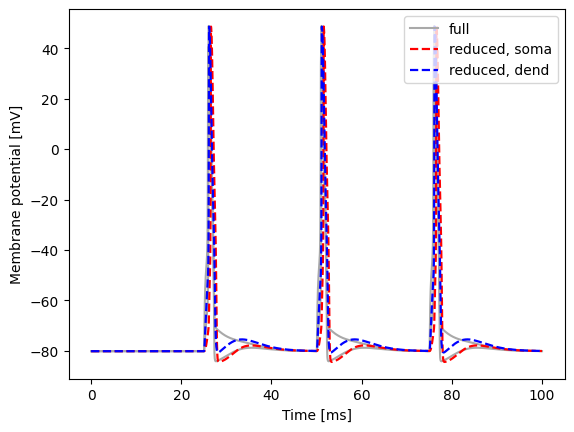

In [47]:
pl.plot(res_full['t'], res_full['v_m'][0], c='DarkGrey', label='full')
pl.plot(res_full['t'], res_full['v_m'][1], c='DarkGrey')
pl.plot(res_reduced['t'], res_reduced['v_m'][0], 'r--', lw=1.6, label='reduced, soma')
pl.plot(res_reduced['t'], res_reduced['v_m'][1], 'b--', lw=1.6, label='reduced, dend')
pl.xlabel('Time [ms]')
pl.ylabel('Membrane potential [mV]')
pl.legend(loc=0)
pl.show()

## Comparison in a point-neuron reduction

This section re-iterates the previous code in a point-neuron setting to see if any differences arise.

In [49]:
# compute a simplified tree containing a somatic compartment only
f_locs = [(1,.5)]
c_tree, c_locs = c_fit.fit_model(f_locs, use_all_channels_for_passive=False) # 

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


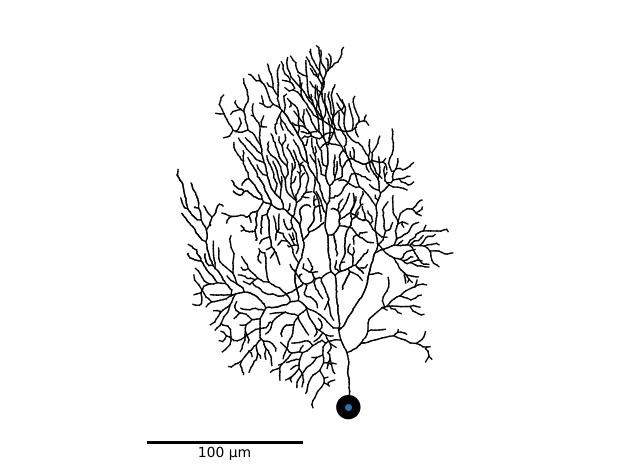

In [50]:
c_fit.check_passive(f_locs, use_all_channels_for_passive=False)

In [51]:
print(c_tree)

>>> CompartmentTree
    CompartmentNode 0, Parent: None --- loc_idx = 0, g_c = 0.0 uS, ca = 0.00013053085971408826 uF, e_eq = -80.13628438385213 mV, (g_L = 0.06227927291877431 uS, e_L = -80.09857121852217 mV), (g_Na_Ta = 73.45466875333844 uS, e_Na_Ta = 50.0 mV), (g_Kv3_1 = 12.961014284617114 uS, e_Kv3_1 = -85.0 mV), (g_KA = 3.4693970705229932e-06 uS, e_KA = -85.0 mV), (g_KD = 3.903073450178491e-06 uS, e_KD = -85.0 mV), (g_CaE = 3.4693988305519527e-07 uS, e_CaE = 135.0 mV), (g_CaP2 = 1.7347029646581472e-07 uS, e_CaP2 = 135.0 mV), (g_SK = 4.3367483307011225e-07 uS, e_SK = -85.0 mV)


In [52]:
# node 0 corresponds to location 0 in `f_locs`
print('node index: %d, loc index: %d'%(c_tree[0].index, c_tree[0].loc_idx))

node index: 0, loc index: 0


In [53]:
c_locs = c_tree.get_equivalent_locs()
print(c_locs[0])

(0, 0.5)


In [54]:
from neat import NeuronCompartmentTree
c_sim_tree = NeuronCompartmentTree(c_tree)

In [55]:
# initialize, run and delete the full model, set input locations as stored in `f_locs`
sim_tree.init_model(t_calibrate=100.)
sim_tree.add_i_clamp(f_locs[0], 0, 5., 200.)
sim_tree.add_double_exp_synapse(f_locs[0], .2, 3., 0.)
#sim_tree.set_spiketrain(0, 0.1, [25.,50.,75.,100.]) 
sim_tree.store_locs(f_locs, name='rec locs')
res_full = sim_tree.run(200.)
sim_tree.delete_model()

# initialize and run the simplified model, set input locations as stored in `c_locs`
c_sim_tree.init_model(t_calibrate=100.)
c_sim_tree.add_i_clamp(c_locs[0], 0, 5., 200.)
c_sim_tree.add_double_exp_synapse(c_locs[0], .2, 3., 0.)
#c_sim_tree.set_spiketrain(0, 0.1, [25.,50.,75.,100.])
c_sim_tree.store_locs(c_locs, name='rec locs')
res_reduced = c_sim_tree.run(200.)
# print the hoc topology of the reduced model
from neuron import h
h.topology()
# delete the reduced model
c_sim_tree.delete_model()


|-|       0(0-1)



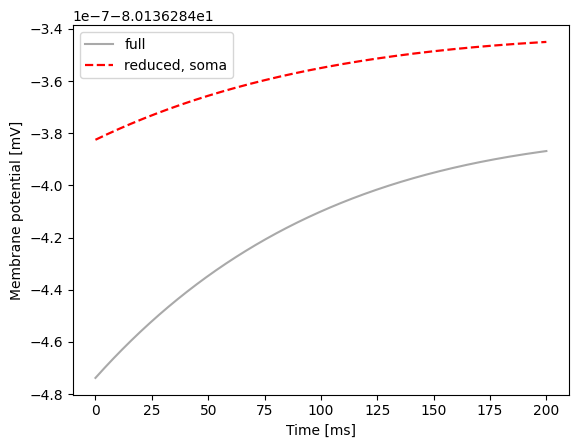

In [56]:
pl.plot(res_full['t'], res_full['v_m'][0], c='DarkGrey', label='full')
pl.plot(res_reduced['t'], res_reduced['v_m'][0], 'r--', lw=1.6, label='reduced, soma')
pl.xlabel('Time [ms]')
pl.ylabel('Membrane potential [mV]')
pl.legend(loc=0)
pl.show()